In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
#from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import ParameterGrid
#from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, plot, plot_components,add_changepoints_to_plot

In [2]:
dataset = pd.read_csv("data.csv")

In [3]:
dataset.ds

0     2020-10-01
1     2020-11-01
2     2020-12-01
3     2021-01-01
4     2021-02-01
5     2021-03-01
6     2021-04-01
7     2021-05-01
8     2021-06-01
9     2021-07-01
10    2021-08-01
11    2021-09-01
12    2021-10-01
13    2021-11-01
14    2021-12-01
15    2022-01-01
16    2022-02-01
17    2022-03-01
18    2022-04-01
19    2022-05-01
20    2022-06-01
21    2022-07-01
22    2022-08-01
23    2022-09-01
24    2022-10-01
25    2022-11-01
26    2022-12-01
27    2023-01-01
28    2023-02-01
29    2023-03-01
30    2023-04-01
31    2023-05-01
32    2023-06-01
33    2023-07-01
34    2023-08-01
35    2023-09-01
36    2023-10-01
37    2023-11-01
38    2023-12-01
Name: ds, dtype: object

In [4]:
# change data type of ds column to pd.datatime as require of model Prophet
dataset['ds'] = pd.to_datetime(dataset['ds'], format='%Y/%m/%d')

# Splitting the data into train and test sets
train = dataset.iloc[:-4]  # Using all except the last 4 months for training
test = dataset.iloc[-4:]  # Using the last 4 months for testing

In [5]:
# using simple MAPE to find the best hyperparameter
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
model = Prophet()

# fit dataset
model.fit(train)

# create future want to predict
future = model.make_future_dataframe(periods=12, freq='MS') # predict next 12 months

# run forecast
forecast = model.predict(future)

12:32:46 - cmdstanpy - INFO - Chain [1] start processing
12:32:46 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# calcualte MAPE

MAPE = mean_absolute_percentage_error(test['y'],abs(forecast['yhat'][35:39]))
print(MAPE)

16.865741038847865


<Figure size 1000x600 with 0 Axes>

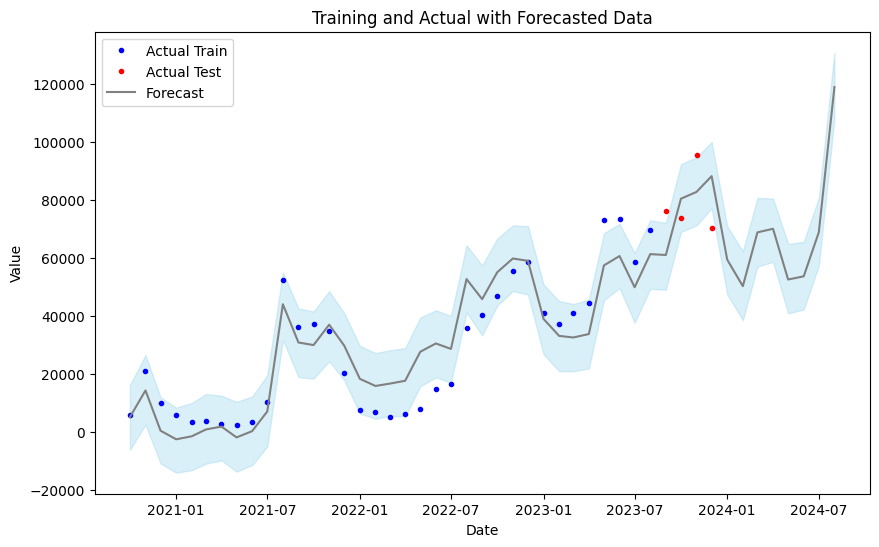

In [8]:
# show results
fig_1 = plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.plot(train["ds"], train["y"], '.', label='Actual Train', color = 'blue')
plt.plot(test["ds"], test["y"], '.', label='Actual Test', color = 'red')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='grey')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='skyblue', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Training and Actual with Forecasted Data')
plt.legend()
plt.show()

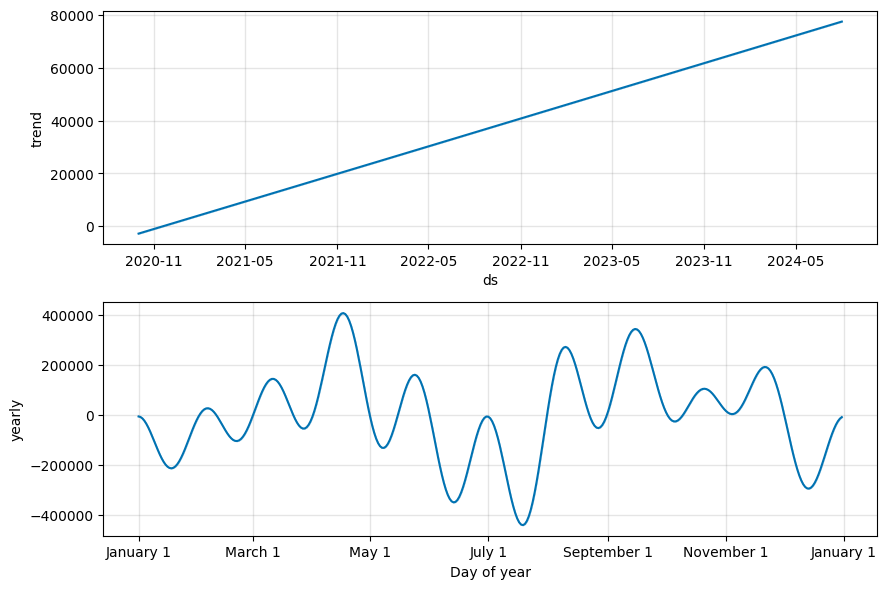

In [9]:
fig_2 = model.plot_components(forecast, plot_cap=20)

### Parameters that can be tuned

**changepoint_prior_scale**: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.

**seasonality_prior_scale**: This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

**holidays_prior_scale**: This controls flexibility to fit holiday effects. Similar to seasonality_prior_scale, it defaults to 10.0 which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of [0.01, 10] as with seasonality_prior_scale.

**seasonality_mode**: Options are ['additive', 'multiplicative']. Default is 'additive', but many business time series will have multiplicative seasonality. This is best identified just from looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series (see the documentation here on multiplicative seasonality), but when that isn’t possible, it could be tuned.

In [10]:
# input hyperparameter want to try
params_grid = {'seasonality_mode':('multiplicative','additive'),
            'changepoint_prior_scale':[0.001, 0.002, 0.003, 0.004, 0.005,
                                        0.01, 0.02, 0.03, 0.04, 0.05,
                                        0.1,0.2, 0.3, 0.4, 0.5],
            'seasonality_prior_scale':[0.01, 0.02, 0.03, 0.04, 0.05,
                                        0.1,0.2, 0.3, 0.4, 0.5,
                                        1.0, 2.0, 3.0, 4.0, 5.0, 10.0]}

# make parameters grid to test
grid = ParameterGrid(params_grid)

# trial numbers
cnt = 0
for p in grid:
    cnt = cnt+1
print('Total Possible Models',cnt)

Total Possible Models 480


In [33]:
# create initial DataFrame
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])

#trial count
_try = 0

# try hyperparameters
for p in grid:
    train_forecast = pd.DataFrame()
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                        seasonality_prior_scale = p['seasonality_prior_scale'],
                        seasonality_mode = p['seasonality_mode'])
    train_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    train_model.fit(train)
    train_forecast = train_model.make_future_dataframe(periods=12, freq='MS')
    train_forecast = train_model.predict(train_forecast)
    train_forecast = train_forecast[['ds','yhat']]
    train_forecast = train_forecast[35:39]
    train_test = test
    MAPE = mean_absolute_percentage_error(train_test['y'],abs(train_forecast['yhat']))
    _try +=1
    print('--------------------------------------------------------------------------------------------------')
    print('try', _try, '-- Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    try_parameter = pd.DataFrame({'MAPE':MAPE,'Parameters':[p]})
    model_parameters = pd.concat([model_parameters,try_parameter],ignore_index=True)

14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] done processing
14:50:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 1 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.08183718152854


14:50:57 - cmdstanpy - INFO - Chain [1] done processing
14:50:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 2 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.438859855965212


14:50:59 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 3 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.407320582920374


14:50:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:00 - cmdstanpy - INFO - Chain [1] done processing
14:51:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 4 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.874431285989353


14:51:01 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 5 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.566232016972211


14:51:01 - cmdstanpy - INFO - Chain [1] start processing
14:51:02 - cmdstanpy - INFO - Chain [1] done processing
14:51:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 6 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.389464405123228


14:51:18 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 7 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.501116828729902


14:51:18 - cmdstanpy - INFO - Chain [1] start processing
14:51:28 - cmdstanpy - INFO - Chain [1] done processing
14:51:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 8 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.91817165424701


14:51:49 - cmdstanpy - INFO - Chain [1] done processing
14:51:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 9 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.57225582842777


14:51:57 - cmdstanpy - INFO - Chain [1] done processing
14:51:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 10 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.77911666020421


14:52:29 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 11 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.150488783640178


14:52:30 - cmdstanpy - INFO - Chain [1] start processing
14:52:44 - cmdstanpy - INFO - Chain [1] done processing
14:52:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 12 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.810887850928193


14:52:48 - cmdstanpy - INFO - Chain [1] done processing
14:52:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 13 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.803374971988223


14:52:53 - cmdstanpy - INFO - Chain [1] done processing
14:52:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 14 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.022938750614678


14:52:56 - cmdstanpy - INFO - Chain [1] done processing
14:52:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 15 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.718577430520227


14:52:57 - cmdstanpy - INFO - Chain [1] done processing
14:52:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 16 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.362764680796545


14:52:59 - cmdstanpy - INFO - Chain [1] done processing
14:52:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 17 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.53800657213007


14:52:59 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 18 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.305672901894603


14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:01 - cmdstanpy - INFO - Chain [1] done processing
14:53:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 19 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.432154108692433


14:53:04 - cmdstanpy - INFO - Chain [1] done processing
14:53:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 20 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.101860615023213


14:53:07 - cmdstanpy - INFO - Chain [1] done processing
14:53:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 21 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.225163010741785


14:53:08 - cmdstanpy - INFO - Chain [1] done processing
14:53:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 22 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.914309148608666


14:53:08 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 23 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.559202777943202


14:53:09 - cmdstanpy - INFO - Chain [1] start processing
14:53:09 - cmdstanpy - INFO - Chain [1] done processing
14:53:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 24 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.30833870376922


14:53:12 - cmdstanpy - INFO - Chain [1] done processing
14:53:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 25 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.108011470217688


14:53:14 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 26 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.421631207553256


14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 27 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.16986559523007


14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 28 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.668351435379527


14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 29 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.955863281847147


14:53:20 - cmdstanpy - INFO - Chain [1] done processing
14:53:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 30 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.47063846497285


14:53:20 - cmdstanpy - INFO - Chain [1] done processing
14:53:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 31 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.587431228322465


14:53:21 - cmdstanpy - INFO - Chain [1] done processing
14:53:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 32 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.676604681233638


14:53:21 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 33 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.772307958987945


14:53:22 - cmdstanpy - INFO - Chain [1] start processing
14:53:22 - cmdstanpy - INFO - Chain [1] done processing
14:53:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 34 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.416921584115684


14:53:23 - cmdstanpy - INFO - Chain [1] done processing
14:53:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 35 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.379345781430963


14:53:24 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 36 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.83661039254191


14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 37 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.570931572050464


14:53:32 - cmdstanpy - INFO - Chain [1] done processing
14:53:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 38 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.243011692415308


14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 39 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.96188126987083


14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 40 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.0791834529904


14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 41 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.682455535111373


14:53:53 - cmdstanpy - INFO - Chain [1] done processing
14:53:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 42 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.017700530783603


14:54:01 - cmdstanpy - INFO - Chain [1] done processing
14:54:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 43 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.1811946341304


14:54:08 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 44 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.31337138629906


14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:14 - cmdstanpy - INFO - Chain [1] done processing
14:54:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 45 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.39979391094072


14:54:16 - cmdstanpy - INFO - Chain [1] done processing
14:54:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 46 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.31256513482753


14:54:18 - cmdstanpy - INFO - Chain [1] done processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 47 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.990416781816357


14:54:20 - cmdstanpy - INFO - Chain [1] done processing
14:54:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 48 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.788455553333456


14:54:20 - cmdstanpy - INFO - Chain [1] done processing
14:54:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 49 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.272109639935465


14:54:21 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 50 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.29035961626434


14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:22 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 51 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.812601965401756


14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:23 - cmdstanpy - INFO - Chain [1] done processing
14:54:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 52 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.910027595097345


14:54:25 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 53 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.290816531106502


14:54:25 - cmdstanpy - INFO - Chain [1] start processing
14:54:26 - cmdstanpy - INFO - Chain [1] done processing
14:54:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 54 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.905280958745644


14:54:27 - cmdstanpy - INFO - Chain [1] done processing
14:54:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 55 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.587075823608425


14:54:27 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 56 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.31042941100801


14:54:28 - cmdstanpy - INFO - Chain [1] start processing
14:54:29 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 57 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.20542997774346


14:54:30 - cmdstanpy - INFO - Chain [1] start processing
14:54:31 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 58 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.651933894851727


14:54:31 - cmdstanpy - INFO - Chain [1] start processing
14:54:32 - cmdstanpy - INFO - Chain [1] done processing
14:54:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 59 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.691959596468116


14:54:34 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 60 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.63536095544487


14:54:34 - cmdstanpy - INFO - Chain [1] start processing
14:54:34 - cmdstanpy - INFO - Chain [1] done processing
14:54:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 61 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.32036078757259


14:54:35 - cmdstanpy - INFO - Chain [1] done processing
14:54:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 62 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.498137136459253


14:54:35 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 63 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.59690092699874


14:54:36 - cmdstanpy - INFO - Chain [1] start processing
14:54:36 - cmdstanpy - INFO - Chain [1] done processing
14:54:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 64 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.91568055143333


14:54:37 - cmdstanpy - INFO - Chain [1] done processing
14:54:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 65 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.6364308453168


14:54:38 - cmdstanpy - INFO - Chain [1] done processing
14:54:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 66 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.0222986617793


14:54:38 - cmdstanpy - INFO - Chain [1] done processing
14:54:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 67 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.399244819912514


14:54:39 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 68 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.83561900989172


14:54:39 - cmdstanpy - INFO - Chain [1] start processing
14:54:40 - cmdstanpy - INFO - Chain [1] done processing
14:54:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 69 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.801439173593637


14:54:42 - cmdstanpy - INFO - Chain [1] done processing
14:54:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 70 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.773616177257464


14:54:47 - cmdstanpy - INFO - Chain [1] done processing
14:54:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 71 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.971657818415267


14:54:48 - cmdstanpy - INFO - Chain [1] done processing
14:54:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 72 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.906902504063996


14:54:49 - cmdstanpy - INFO - Chain [1] done processing
14:54:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 73 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.647059680288795


14:54:50 - cmdstanpy - INFO - Chain [1] done processing
14:54:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 74 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.050650602527064


14:54:51 - cmdstanpy - INFO - Chain [1] done processing
14:54:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 75 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.40439435560221


14:54:54 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 76 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.1485217697429


14:54:54 - cmdstanpy - INFO - Chain [1] start processing
14:54:55 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 77 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.50234512391161


14:54:55 - cmdstanpy - INFO - Chain [1] start processing
14:54:56 - cmdstanpy - INFO - Chain [1] done processing
14:54:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 78 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.74484715310748


14:55:02 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 79 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.445037225686946


14:55:02 - cmdstanpy - INFO - Chain [1] start processing
14:55:03 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 80 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.737819914238145


14:55:04 - cmdstanpy - INFO - Chain [1] start processing
14:55:04 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 81 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.34366599941824


14:55:04 - cmdstanpy - INFO - Chain [1] start processing
14:55:06 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 82 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.268371435599395


14:55:06 - cmdstanpy - INFO - Chain [1] start processing
14:55:06 - cmdstanpy - INFO - Chain [1] done processing
14:55:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 83 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.799335702001798


14:55:07 - cmdstanpy - INFO - Chain [1] done processing
14:55:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 84 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.902717082987921


14:55:08 - cmdstanpy - INFO - Chain [1] done processing
14:55:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 85 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.454339314576234


14:55:09 - cmdstanpy - INFO - Chain [1] done processing
14:55:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 86 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.90361839911583


14:55:09 - cmdstanpy - INFO - Chain [1] done processing
14:55:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 87 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.57984392191643


14:55:10 - cmdstanpy - INFO - Chain [1] done processing
14:55:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 88 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.324214089667228


14:55:11 - cmdstanpy - INFO - Chain [1] done processing
14:55:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 89 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.25604169806334


14:55:12 - cmdstanpy - INFO - Chain [1] done processing
14:55:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 90 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.94579236624133


14:55:12 - cmdstanpy - INFO - Chain [1] done processing
14:55:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 91 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.596556510255173


14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 92 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.38043657067083


14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 93 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.309086413264996


14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 94 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.497184549650193


14:55:15 - cmdstanpy - INFO - Chain [1] done processing
14:55:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 95 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.610481587831057


14:55:15 - cmdstanpy - INFO - Chain [1] done processing
14:55:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 96 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.947762155810167


14:55:16 - cmdstanpy - INFO - Chain [1] done processing
14:55:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 97 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.62496499131878


14:55:16 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 98 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.021928251908854


14:55:16 - cmdstanpy - INFO - Chain [1] start processing
14:55:17 - cmdstanpy - INFO - Chain [1] done processing
14:55:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 99 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.3394903005275


14:55:18 - cmdstanpy - INFO - Chain [1] done processing
14:55:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 100 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.896313605741046


14:55:18 - cmdstanpy - INFO - Chain [1] done processing
14:55:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 101 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.79585115564886


14:55:19 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 102 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.915706929826984


14:55:19 - cmdstanpy - INFO - Chain [1] start processing
14:55:22 - cmdstanpy - INFO - Chain [1] done processing
14:55:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 103 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.879519911481733


14:55:23 - cmdstanpy - INFO - Chain [1] done processing
14:55:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 104 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.950778252683225


14:55:23 - cmdstanpy - INFO - Chain [1] done processing
14:55:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 105 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.837037942435597


14:55:26 - cmdstanpy - INFO - Chain [1] done processing
14:55:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 106 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.971479080350413


14:55:29 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 107 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.08324310538993


14:55:29 - cmdstanpy - INFO - Chain [1] start processing
14:55:33 - cmdstanpy - INFO - Chain [1] done processing
14:55:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 108 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.06616042458227


14:55:35 - cmdstanpy - INFO - Chain [1] done processing
14:55:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 109 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.66881105207883


14:55:37 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 110 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.07224200567833


14:55:37 - cmdstanpy - INFO - Chain [1] start processing
14:55:39 - cmdstanpy - INFO - Chain [1] done processing
14:55:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 111 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.625333067453376


14:55:39 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 112 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.88403777307105


14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 113 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.164275531250826


14:55:40 - cmdstanpy - INFO - Chain [1] done processing
14:55:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 114 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.278239431766778


14:55:41 - cmdstanpy - INFO - Chain [1] done processing
14:55:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 115 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.801560978685641


14:55:41 - cmdstanpy - INFO - Chain [1] done processing
14:55:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 116 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.79749964211391


14:55:42 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 117 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.630897548306216


14:55:42 - cmdstanpy - INFO - Chain [1] start processing
14:55:43 - cmdstanpy - INFO - Chain [1] done processing
14:55:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 118 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.904241799015304


14:55:43 - cmdstanpy - INFO - Chain [1] done processing
14:55:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 119 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.617159085166332


14:55:44 - cmdstanpy - INFO - Chain [1] done processing
14:55:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 120 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.315114654785017


14:55:44 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 121 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.283933570859777


14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] done processing
14:55:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 122 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.945371781596728


14:55:46 - cmdstanpy - INFO - Chain [1] done processing
14:55:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 123 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.00377726761085


14:55:46 - cmdstanpy - INFO - Chain [1] done processing
14:55:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 124 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.146699071149865


14:55:47 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 125 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.308146612452077


14:55:47 - cmdstanpy - INFO - Chain [1] start processing
14:55:47 - cmdstanpy - INFO - Chain [1] done processing
14:55:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 126 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.496898083608194


14:55:48 - cmdstanpy - INFO - Chain [1] done processing
14:55:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 127 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.613011523357887


14:55:48 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 128 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.281862900022272


14:55:49 - cmdstanpy - INFO - Chain [1] start processing
14:55:49 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 129 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.673671452056674


14:55:49 - cmdstanpy - INFO - Chain [1] start processing
14:55:50 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 130 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.045914819269175


14:55:51 - cmdstanpy - INFO - Chain [1] start processing
14:55:51 - cmdstanpy - INFO - Chain [1] done processing
14:55:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 131 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.353428474273844


14:55:52 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 132 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.929119235511696


14:55:52 - cmdstanpy - INFO - Chain [1] start processing
14:55:52 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 133 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.77921163824879


14:55:53 - cmdstanpy - INFO - Chain [1] start processing
14:55:53 - cmdstanpy - INFO - Chain [1] done processing
14:55:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 134 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.748647969604267


14:55:55 - cmdstanpy - INFO - Chain [1] done processing
14:55:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 135 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.499092952344604


14:55:56 - cmdstanpy - INFO - Chain [1] done processing
14:55:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 136 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.78033429797219


14:55:57 - cmdstanpy - INFO - Chain [1] done processing
14:55:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 137 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.68301050819626


14:56:00 - cmdstanpy - INFO - Chain [1] done processing
14:56:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 138 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.17143891316162


14:56:05 - cmdstanpy - INFO - Chain [1] done processing
14:56:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 139 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.151889172433634


14:56:08 - cmdstanpy - INFO - Chain [1] done processing
14:56:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 140 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.07518242782286


14:56:11 - cmdstanpy - INFO - Chain [1] done processing
14:56:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 141 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.457112401998515


14:56:12 - cmdstanpy - INFO - Chain [1] done processing
14:56:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 142 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.554788254904565


14:56:15 - cmdstanpy - INFO - Chain [1] done processing
14:56:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 143 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.88844986609516


14:56:15 - cmdstanpy - INFO - Chain [1] done processing
14:56:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 144 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.390332034461714


14:56:16 - cmdstanpy - INFO - Chain [1] done processing
14:56:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 145 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.722207376699696


14:56:17 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 146 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.222089463233047


14:56:17 - cmdstanpy - INFO - Chain [1] start processing
14:56:17 - cmdstanpy - INFO - Chain [1] done processing
14:56:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 147 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.772498876301391


14:56:18 - cmdstanpy - INFO - Chain [1] done processing
14:56:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 148 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.779774344265416


14:56:19 - cmdstanpy - INFO - Chain [1] done processing
14:56:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 149 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.57142845856407


14:56:19 - cmdstanpy - INFO - Chain [1] done processing
14:56:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 150 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.890217007604956


14:56:20 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 151 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.610718184757467


14:56:20 - cmdstanpy - INFO - Chain [1] start processing
14:56:20 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 152 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.382566193162628


14:56:21 - cmdstanpy - INFO - Chain [1] start processing
14:56:21 - cmdstanpy - INFO - Chain [1] done processing
14:56:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 153 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.333293401333158


14:56:22 - cmdstanpy - INFO - Chain [1] done processing
14:56:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 154 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.142496633570577


14:56:22 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 155 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.002167115457066


14:56:23 - cmdstanpy - INFO - Chain [1] start processing
14:56:23 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 156 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.975538157678717


14:56:23 - cmdstanpy - INFO - Chain [1] start processing
14:56:24 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 157 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.299753926865666


14:56:24 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 158 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.495804889581557


14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 159 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.644225441003936


14:56:26 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 160 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.281814291138378


14:56:26 - cmdstanpy - INFO - Chain [1] start processing
14:56:27 - cmdstanpy - INFO - Chain [1] done processing
14:56:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 161 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.18434697183013


14:56:27 - cmdstanpy - INFO - Chain [1] done processing
14:56:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 162 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.452082197594915


14:56:28 - cmdstanpy - INFO - Chain [1] done processing
14:56:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 163 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.11079203382755


14:56:28 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 164 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.722040432372136


14:56:28 - cmdstanpy - INFO - Chain [1] start processing
14:56:29 - cmdstanpy - INFO - Chain [1] done processing
14:56:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 165 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.765811242811331


14:56:29 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 166 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.252078745248138


14:56:30 - cmdstanpy - INFO - Chain [1] start processing
14:56:30 - cmdstanpy - INFO - Chain [1] done processing
14:56:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 167 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.842638294139277


14:56:31 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 168 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.944898021792767


14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:33 - cmdstanpy - INFO - Chain [1] done processing
14:56:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 169 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.755091209739717


14:56:33 - cmdstanpy - INFO - Chain [1] done processing
14:56:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 170 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.48927598441651


14:56:36 - cmdstanpy - INFO - Chain [1] done processing
14:56:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 171 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.36670330532361


14:56:36 - cmdstanpy - INFO - Chain [1] done processing
14:56:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 172 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.72338073578978


14:56:37 - cmdstanpy - INFO - Chain [1] done processing
14:56:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 173 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.75885943884418


14:56:38 - cmdstanpy - INFO - Chain [1] done processing
14:56:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 174 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.870499595362595


14:56:40 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 175 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.44594653596094


14:56:41 - cmdstanpy - INFO - Chain [1] start processing
14:56:42 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 176 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.60491320532145


14:56:42 - cmdstanpy - INFO - Chain [1] start processing
14:56:43 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 177 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.695133986015705


14:56:43 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 178 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.984025944723406


14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:45 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 179 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.732982704072048


14:56:45 - cmdstanpy - INFO - Chain [1] start processing
14:56:45 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 180 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.721976920456232


14:56:46 - cmdstanpy - INFO - Chain [1] start processing
14:56:46 - cmdstanpy - INFO - Chain [1] done processing
14:56:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 181 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.72483415942716


14:56:46 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 182 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.895506744696423


14:56:47 - cmdstanpy - INFO - Chain [1] start processing
14:56:47 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 183 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.646069636748352


14:56:47 - cmdstanpy - INFO - Chain [1] start processing
14:56:48 - cmdstanpy - INFO - Chain [1] done processing
14:56:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 184 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.3826662616175


14:56:48 - cmdstanpy - INFO - Chain [1] done processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 185 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.337049930222289


14:56:49 - cmdstanpy - INFO - Chain [1] done processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 186 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.305536458323386


14:56:49 - cmdstanpy - INFO - Chain [1] done processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 187 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.734859832403608


14:56:50 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 188 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.00345511502157


14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing
14:56:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 189 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.024754743729527


14:56:51 - cmdstanpy - INFO - Chain [1] done processing
14:56:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 190 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.489518056744746


14:56:51 - cmdstanpy - INFO - Chain [1] done processing
14:56:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 191 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.644752683802974


14:56:52 - cmdstanpy - INFO - Chain [1] done processing
14:56:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 192 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.26922914488965


14:56:52 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 193 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.37190462310907


14:56:53 - cmdstanpy - INFO - Chain [1] start processing
14:56:53 - cmdstanpy - INFO - Chain [1] done processing
14:56:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 194 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.559515956659126


14:56:53 - cmdstanpy - INFO - Chain [1] done processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 195 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.105063114667363


14:56:54 - cmdstanpy - INFO - Chain [1] done processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 196 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.68405354599782


14:56:54 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 197 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.56723835095815


14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 198 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.626282359952015


14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:56 - cmdstanpy - INFO - Chain [1] done processing
14:56:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 199 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.237557763261627


14:56:56 - cmdstanpy - INFO - Chain [1] done processing
14:56:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 200 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.10729348727892


14:56:57 - cmdstanpy - INFO - Chain [1] done processing
14:56:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 201 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.97221578140597


14:56:58 - cmdstanpy - INFO - Chain [1] done processing
14:56:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 202 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.554137132754978


14:56:59 - cmdstanpy - INFO - Chain [1] done processing
14:56:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 203 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.860298221277894


14:57:00 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 204 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.81493105360589


14:57:00 - cmdstanpy - INFO - Chain [1] start processing
14:57:01 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 205 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.90651122139112


14:57:01 - cmdstanpy - INFO - Chain [1] start processing
14:57:02 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 206 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.37160398838308


14:57:02 - cmdstanpy - INFO - Chain [1] start processing
14:57:04 - cmdstanpy - INFO - Chain [1] done processing
14:57:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 207 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.975844481360454


14:57:05 - cmdstanpy - INFO - Chain [1] done processing
14:57:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 208 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.02849587723834


14:57:06 - cmdstanpy - INFO - Chain [1] done processing
14:57:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 209 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.728238439910893


14:57:06 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 210 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.900961531181874


14:57:07 - cmdstanpy - INFO - Chain [1] start processing
14:57:07 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 211 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.464770451862641


14:57:07 - cmdstanpy - INFO - Chain [1] start processing
14:57:08 - cmdstanpy - INFO - Chain [1] done processing
14:57:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 212 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.110577991270615


14:57:08 - cmdstanpy - INFO - Chain [1] done processing
14:57:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 213 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.85552234957678


14:57:09 - cmdstanpy - INFO - Chain [1] done processing
14:57:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 214 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.879477330514552


14:57:09 - cmdstanpy - INFO - Chain [1] done processing
14:57:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 215 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.646406850914008


14:57:10 - cmdstanpy - INFO - Chain [1] done processing
14:57:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 216 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.395016059414468


14:57:10 - cmdstanpy - INFO - Chain [1] done processing
14:57:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 217 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.337049966516101


14:57:11 - cmdstanpy - INFO - Chain [1] done processing
14:57:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 218 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.547914147113833


14:57:11 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 219 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.875695241151067


14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 220 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.9549950600798


14:57:13 - cmdstanpy - INFO - Chain [1] done processing
14:57:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 221 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.02474513689046


14:57:13 - cmdstanpy - INFO - Chain [1] done processing
14:57:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 222 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.490003885688665


14:57:14 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 223 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.648293559717345


14:57:14 - cmdstanpy - INFO - Chain [1] start processing
14:57:14 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 224 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.25801326724952


14:57:15 - cmdstanpy - INFO - Chain [1] start processing
14:57:15 - cmdstanpy - INFO - Chain [1] done processing
14:57:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 225 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.533180984847597


14:57:15 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 226 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.15532942414935


14:57:16 - cmdstanpy - INFO - Chain [1] start processing
14:57:16 - cmdstanpy - INFO - Chain [1] done processing
14:57:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 227 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.09002112254086


14:57:17 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 228 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.597076377298283


14:57:17 - cmdstanpy - INFO - Chain [1] start processing
14:57:17 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 229 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.563893220354041


14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 230 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.554179739759846


14:57:18 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 231 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.201632075870066


14:57:19 - cmdstanpy - INFO - Chain [1] start processing
14:57:19 - cmdstanpy - INFO - Chain [1] done processing
14:57:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 232 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.141386385749534


14:57:20 - cmdstanpy - INFO - Chain [1] done processing
14:57:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 233 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.842808945698252


14:57:21 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 234 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.586162779062683


14:57:22 - cmdstanpy - INFO - Chain [1] start processing
14:57:23 - cmdstanpy - INFO - Chain [1] done processing
14:57:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 235 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.943617380955615


14:57:24 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 236 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.62362007636526


14:57:25 - cmdstanpy - INFO - Chain [1] start processing
14:57:25 - cmdstanpy - INFO - Chain [1] done processing
14:57:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 237 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.11829105411754


14:57:26 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 238 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.273594167439214


14:57:26 - cmdstanpy - INFO - Chain [1] start processing
14:57:28 - cmdstanpy - INFO - Chain [1] done processing
14:57:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 239 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.252210092895595


14:57:30 - cmdstanpy - INFO - Chain [1] done processing
14:57:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 240 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.34570199228696


14:57:31 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 241 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.322341003008333


14:57:31 - cmdstanpy - INFO - Chain [1] start processing
14:57:32 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 242 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.896194228719306


14:57:32 - cmdstanpy - INFO - Chain [1] start processing
14:57:32 - cmdstanpy - INFO - Chain [1] done processing
14:57:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 243 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.413463099428418


14:57:33 - cmdstanpy - INFO - Chain [1] done processing
14:57:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 244 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.885559118968045


14:57:33 - cmdstanpy - INFO - Chain [1] done processing
14:57:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 245 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.854469769305505


14:57:34 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 246 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.897194062368078


14:57:34 - cmdstanpy - INFO - Chain [1] start processing
14:57:34 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 247 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.64626126724095


14:57:35 - cmdstanpy - INFO - Chain [1] start processing
14:57:35 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 248 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.371164159272649


14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 249 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.333949026585875


14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:37 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 250 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.545759118013558


14:57:38 - cmdstanpy - INFO - Chain [1] start processing
14:57:38 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 251 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.882530417415435


14:57:39 - cmdstanpy - INFO - Chain [1] start processing
14:57:39 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 252 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.9642699829467


14:57:40 - cmdstanpy - INFO - Chain [1] start processing
14:57:40 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 253 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.02377021060961


14:57:41 - cmdstanpy - INFO - Chain [1] start processing
14:57:41 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 254 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.491313613932032


14:57:42 - cmdstanpy - INFO - Chain [1] start processing
14:57:42 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 255 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.749164320171413


14:57:42 - cmdstanpy - INFO - Chain [1] start processing
14:57:43 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 256 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.25275560585426


14:57:43 - cmdstanpy - INFO - Chain [1] start processing
14:57:44 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 257 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.70222307388819


14:57:44 - cmdstanpy - INFO - Chain [1] start processing
14:57:45 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 258 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.186077937027374


14:57:45 - cmdstanpy - INFO - Chain [1] start processing
14:57:45 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 259 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.306970816776346


14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] done processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 260 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.667426794124193


14:57:47 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 261 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.760110418124357


14:57:47 - cmdstanpy - INFO - Chain [1] start processing
14:57:48 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 262 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.436859630640377


14:57:48 - cmdstanpy - INFO - Chain [1] start processing
14:57:49 - cmdstanpy - INFO - Chain [1] done processing
14:57:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 263 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.130978839482434


14:57:50 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 264 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.131763736402235


14:57:50 - cmdstanpy - INFO - Chain [1] start processing
14:57:51 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 265 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.1457521840032


14:57:51 - cmdstanpy - INFO - Chain [1] start processing
14:57:53 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 266 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.5657579748149


14:57:53 - cmdstanpy - INFO - Chain [1] start processing
14:57:54 - cmdstanpy - INFO - Chain [1] done processing
14:57:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 267 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.81018559944873


14:57:55 - cmdstanpy - INFO - Chain [1] done processing
14:57:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 268 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.750755552606485


14:57:57 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 269 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.06350314053541


14:57:59 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 270 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.18874597348525


14:57:59 - cmdstanpy - INFO - Chain [1] start processing
14:58:03 - cmdstanpy - INFO - Chain [1] done processing
14:58:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 271 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.09036674855164


14:58:10 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 272 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.767580411234945


14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 273 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.334189345643402


14:58:11 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 274 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.94592208444026


14:58:12 - cmdstanpy - INFO - Chain [1] start processing
14:58:12 - cmdstanpy - INFO - Chain [1] done processing
14:58:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 275 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.454036120147421


14:58:13 - cmdstanpy - INFO - Chain [1] done processing
14:58:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 276 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.870831057349477


14:58:13 - cmdstanpy - INFO - Chain [1] done processing
14:58:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 277 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.868583044223007


14:58:14 - cmdstanpy - INFO - Chain [1] done processing
14:58:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 278 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.871912374022825


14:58:14 - cmdstanpy - INFO - Chain [1] done processing
14:58:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 279 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.646182859022016


14:58:15 - cmdstanpy - INFO - Chain [1] done processing
14:58:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 280 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.381493657121236


14:58:15 - cmdstanpy - INFO - Chain [1] done processing
14:58:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 281 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.327451159867175


14:58:16 - cmdstanpy - INFO - Chain [1] done processing
14:58:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 282 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.54448250001681


14:58:17 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 283 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.87797012940607


14:58:17 - cmdstanpy - INFO - Chain [1] start processing
14:58:17 - cmdstanpy - INFO - Chain [1] done processing
14:58:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 284 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.958835461736555


14:58:18 - cmdstanpy - INFO - Chain [1] done processing
14:58:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 285 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.025359255577857


14:58:19 - cmdstanpy - INFO - Chain [1] done processing
14:58:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 286 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.491519239602905


14:58:19 - cmdstanpy - INFO - Chain [1] done processing
14:58:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 287 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.764652033852997


14:58:20 - cmdstanpy - INFO - Chain [1] done processing
14:58:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 288 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.254964426704706


14:58:20 - cmdstanpy - INFO - Chain [1] done processing
14:58:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 289 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.96374507355195


14:58:21 - cmdstanpy - INFO - Chain [1] done processing
14:58:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 290 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.33484079203738


14:58:21 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 291 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.109566256388728


14:58:22 - cmdstanpy - INFO - Chain [1] start processing
14:58:22 - cmdstanpy - INFO - Chain [1] done processing
14:58:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 292 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.62563519569382


14:58:23 - cmdstanpy - INFO - Chain [1] done processing
14:58:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 293 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.559033886976293


14:58:23 - cmdstanpy - INFO - Chain [1] done processing
14:58:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 294 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.64388110253818


14:58:24 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 295 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.24283542081925


14:58:25 - cmdstanpy - INFO - Chain [1] start processing
14:58:25 - cmdstanpy - INFO - Chain [1] done processing
14:58:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 296 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.107580505796943


14:58:26 - cmdstanpy - INFO - Chain [1] done processing
14:58:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 297 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.024505470701747


14:58:26 - cmdstanpy - INFO - Chain [1] done processing
14:58:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 298 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.691592927967164


14:58:27 - cmdstanpy - INFO - Chain [1] done processing
14:58:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 299 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.990624737899246


14:58:28 - cmdstanpy - INFO - Chain [1] done processing
14:58:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 300 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.601074033295724


14:58:30 - cmdstanpy - INFO - Chain [1] done processing
14:58:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 301 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.15100935430952


14:58:31 - cmdstanpy - INFO - Chain [1] done processing
14:58:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 302 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.28748869570914


14:58:32 - cmdstanpy - INFO - Chain [1] done processing
14:58:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 303 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.47018728522414


14:58:35 - cmdstanpy - INFO - Chain [1] done processing
14:58:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 304 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.95469063341289


14:58:36 - cmdstanpy - INFO - Chain [1] done processing
14:58:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 305 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.272782652575803


14:58:36 - cmdstanpy - INFO - Chain [1] done processing
14:58:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 306 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.89501626455728


14:58:37 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 307 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.480420839218755


14:58:37 - cmdstanpy - INFO - Chain [1] start processing
14:58:38 - cmdstanpy - INFO - Chain [1] done processing
14:58:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 308 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.84860021643707


14:58:38 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 309 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.880169625449726


14:58:39 - cmdstanpy - INFO - Chain [1] start processing
14:58:39 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 310 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.88784073725538


14:58:39 - cmdstanpy - INFO - Chain [1] start processing
14:58:40 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 311 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.642544345131878


14:58:41 - cmdstanpy - INFO - Chain [1] start processing
14:58:41 - cmdstanpy - INFO - Chain [1] done processing
14:58:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 312 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.375387278769013


14:58:42 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 313 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.330218313757587


14:58:42 - cmdstanpy - INFO - Chain [1] start processing
14:58:42 - cmdstanpy - INFO - Chain [1] done processing
14:58:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 314 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.540446350553792


14:58:43 - cmdstanpy - INFO - Chain [1] done processing
14:58:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 315 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.926034909956737


14:58:44 - cmdstanpy - INFO - Chain [1] done processing
14:58:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 316 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.969466287857657


14:58:44 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 317 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.02758905062595


14:58:45 - cmdstanpy - INFO - Chain [1] start processing
14:58:45 - cmdstanpy - INFO - Chain [1] done processing
14:58:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 318 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.49321658778761


14:58:46 - cmdstanpy - INFO - Chain [1] done processing
14:58:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 319 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.773673929494052


14:58:46 - cmdstanpy - INFO - Chain [1] done processing
14:58:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 320 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.252765708019552


14:58:47 - cmdstanpy - INFO - Chain [1] done processing
14:58:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 321 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.797257240996938


14:58:47 - cmdstanpy - INFO - Chain [1] done processing
14:58:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 322 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.132960525501524


14:58:48 - cmdstanpy - INFO - Chain [1] done processing
14:58:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 323 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.134323955941124


14:58:48 - cmdstanpy - INFO - Chain [1] done processing
14:58:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 324 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.613601517409563


14:58:49 - cmdstanpy - INFO - Chain [1] done processing
14:58:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 325 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.60055960837197


14:58:50 - cmdstanpy - INFO - Chain [1] done processing
14:58:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 326 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.58186218000975


14:58:51 - cmdstanpy - INFO - Chain [1] done processing
14:58:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 327 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.28182076831801


14:58:52 - cmdstanpy - INFO - Chain [1] done processing
14:58:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 328 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.20181666550655


14:58:53 - cmdstanpy - INFO - Chain [1] done processing
14:58:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 329 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.08482295553927


14:58:53 - cmdstanpy - INFO - Chain [1] done processing
14:58:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 330 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.687099178149275


14:58:54 - cmdstanpy - INFO - Chain [1] done processing
14:58:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 331 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.925913336739825


14:58:55 - cmdstanpy - INFO - Chain [1] done processing
14:58:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 332 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.87739315774343


14:58:56 - cmdstanpy - INFO - Chain [1] done processing
14:58:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 333 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.19151719141807


14:58:57 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 334 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.39080471169847


14:58:58 - cmdstanpy - INFO - Chain [1] start processing
14:58:59 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 335 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.70606749481356


14:58:59 - cmdstanpy - INFO - Chain [1] start processing
14:59:00 - cmdstanpy - INFO - Chain [1] done processing
14:59:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 336 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 40.17910397409761


14:59:01 - cmdstanpy - INFO - Chain [1] done processing
14:59:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 337 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.218617471556914


14:59:01 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 338 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.89810365567425


14:59:02 - cmdstanpy - INFO - Chain [1] start processing
14:59:02 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 339 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.42366584242231


14:59:02 - cmdstanpy - INFO - Chain [1] start processing
14:59:03 - cmdstanpy - INFO - Chain [1] done processing
14:59:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 340 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.842681730609621


14:59:03 - cmdstanpy - INFO - Chain [1] done processing
14:59:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 341 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.869726149264263


14:59:04 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 342 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.90255453021542


14:59:04 - cmdstanpy - INFO - Chain [1] start processing
14:59:04 - cmdstanpy - INFO - Chain [1] done processing
14:59:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 343 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.642493010835441


14:59:05 - cmdstanpy - INFO - Chain [1] done processing
14:59:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 344 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.379173634533736


14:59:06 - cmdstanpy - INFO - Chain [1] done processing
14:59:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 345 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.325626364256905


14:59:06 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 346 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.238962853764736


14:59:07 - cmdstanpy - INFO - Chain [1] start processing
14:59:07 - cmdstanpy - INFO - Chain [1] done processing
14:59:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 347 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.47274032964155


14:59:08 - cmdstanpy - INFO - Chain [1] done processing
14:59:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 348 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.1924617176154


14:59:08 - cmdstanpy - INFO - Chain [1] done processing
14:59:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 349 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.476478813033832


14:59:09 - cmdstanpy - INFO - Chain [1] done processing
14:59:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 350 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.130059297954546


14:59:10 - cmdstanpy - INFO - Chain [1] done processing
14:59:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 351 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.00819797244546


14:59:10 - cmdstanpy - INFO - Chain [1] done processing
14:59:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 352 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.588481800902247


14:59:11 - cmdstanpy - INFO - Chain [1] done processing
14:59:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 353 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.866078521767994


14:59:12 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 354 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.56832718655323


14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] done processing
14:59:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 355 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.727893372858674


14:59:13 - cmdstanpy - INFO - Chain [1] done processing
14:59:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 356 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.871246746136997


14:59:13 - cmdstanpy - INFO - Chain [1] done processing
14:59:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 357 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.786207758259694


14:59:14 - cmdstanpy - INFO - Chain [1] done processing
14:59:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 358 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.543080140230643


14:59:16 - cmdstanpy - INFO - Chain [1] done processing
14:59:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 359 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.255843794758263


14:59:17 - cmdstanpy - INFO - Chain [1] done processing
14:59:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 360 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.204981547939397


14:59:18 - cmdstanpy - INFO - Chain [1] done processing
14:59:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 361 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.137568857670544


14:59:19 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 362 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.68010991776326


14:59:19 - cmdstanpy - INFO - Chain [1] start processing
14:59:20 - cmdstanpy - INFO - Chain [1] done processing
14:59:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 363 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.9566250706505


14:59:21 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 364 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 68.82104926353621


14:59:21 - cmdstanpy - INFO - Chain [1] start processing
15:00:07 - cmdstanpy - INFO - Chain [1] done processing
15:00:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 365 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 86.32214359040222


15:00:57 - cmdstanpy - INFO - Chain [1] done processing
15:00:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 366 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 77.66566280116871


15:01:43 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 367 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 93.13294427738813


15:01:43 - cmdstanpy - INFO - Chain [1] start processing
15:02:38 - cmdstanpy - INFO - Chain [1] done processing
15:02:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 368 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.048002394698287


15:02:39 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 369 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.0984810577361


15:02:39 - cmdstanpy - INFO - Chain [1] start processing
15:02:40 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 370 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.046941138819607


15:02:40 - cmdstanpy - INFO - Chain [1] start processing
15:02:41 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 371 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.939195568429225


15:02:41 - cmdstanpy - INFO - Chain [1] start processing
15:02:41 - cmdstanpy - INFO - Chain [1] done processing
15:02:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 372 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.307678404468293


15:02:42 - cmdstanpy - INFO - Chain [1] done processing
15:02:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 373 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.095306116088231


15:02:43 - cmdstanpy - INFO - Chain [1] done processing
15:02:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 374 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.882588288187


15:02:44 - cmdstanpy - INFO - Chain [1] done processing
15:02:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 375 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.203410505921822


15:02:44 - cmdstanpy - INFO - Chain [1] done processing
15:02:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 376 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.061212917516801


15:02:45 - cmdstanpy - INFO - Chain [1] done processing
15:02:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 377 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.6854798756379


15:02:46 - cmdstanpy - INFO - Chain [1] done processing
15:02:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 378 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.36036763579344


15:02:47 - cmdstanpy - INFO - Chain [1] done processing
15:02:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 379 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.77858358661583


15:02:47 - cmdstanpy - INFO - Chain [1] done processing
15:02:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 380 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.773182759628536


15:02:49 - cmdstanpy - INFO - Chain [1] done processing
15:02:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 381 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.1598609493997


15:02:49 - cmdstanpy - INFO - Chain [1] done processing
15:02:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 382 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.760503671214494


15:02:51 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 383 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.97833334998435


15:02:51 - cmdstanpy - INFO - Chain [1] start processing
15:02:52 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 384 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.0393417524618


15:02:52 - cmdstanpy - INFO - Chain [1] start processing
15:02:53 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 385 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.513103872733964


15:02:53 - cmdstanpy - INFO - Chain [1] start processing
15:02:54 - cmdstanpy - INFO - Chain [1] done processing
15:02:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 386 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.099780107873334


15:02:55 - cmdstanpy - INFO - Chain [1] done processing
15:02:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 387 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.408328913115394


15:02:55 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 388 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.253917334346351


15:02:56 - cmdstanpy - INFO - Chain [1] start processing
15:02:56 - cmdstanpy - INFO - Chain [1] done processing
15:02:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 389 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.64410129275472


15:02:57 - cmdstanpy - INFO - Chain [1] done processing
15:02:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 390 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.826844310181714


15:02:59 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 391 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.25460874755587


15:02:59 - cmdstanpy - INFO - Chain [1] start processing
15:03:00 - cmdstanpy - INFO - Chain [1] done processing
15:03:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 392 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.21595436130739


15:03:02 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 393 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.142473268375138


15:03:02 - cmdstanpy - INFO - Chain [1] start processing
15:03:03 - cmdstanpy - INFO - Chain [1] done processing
15:03:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 394 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.708718015569996


15:03:04 - cmdstanpy - INFO - Chain [1] done processing
15:03:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 395 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 69.56088234479778


15:03:54 - cmdstanpy - INFO - Chain [1] done processing
15:03:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 396 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 78.00503241800499


15:04:42 - cmdstanpy - INFO - Chain [1] done processing
15:04:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 397 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 46.9076372205105


15:05:35 - cmdstanpy - INFO - Chain [1] done processing
15:05:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 398 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 74.21039056265668


15:05:38 - cmdstanpy - INFO - Chain [1] done processing
15:05:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 399 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 71.75423668766341


15:06:36 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 400 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 41.93089968911369


15:06:37 - cmdstanpy - INFO - Chain [1] start processing
15:06:37 - cmdstanpy - INFO - Chain [1] done processing
15:06:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 401 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.838270138138265


15:06:38 - cmdstanpy - INFO - Chain [1] done processing
15:06:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 402 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.266183800471218


15:06:39 - cmdstanpy - INFO - Chain [1] done processing
15:06:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 403 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.334115174699226


15:06:40 - cmdstanpy - INFO - Chain [1] done processing
15:06:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 404 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.864837029356513


15:06:41 - cmdstanpy - INFO - Chain [1] done processing
15:06:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 405 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.505447438555413


15:06:42 - cmdstanpy - INFO - Chain [1] done processing
15:06:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 406 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.331579952700706


15:06:43 - cmdstanpy - INFO - Chain [1] done processing
15:06:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 407 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.318649829510527


15:06:44 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 408 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.39854476452542


15:06:45 - cmdstanpy - INFO - Chain [1] start processing
15:06:46 - cmdstanpy - INFO - Chain [1] done processing
15:06:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 409 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.056989648153767


15:06:47 - cmdstanpy - INFO - Chain [1] done processing
15:06:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 410 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.160718446305744


15:06:47 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 411 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.238540370444976


15:06:48 - cmdstanpy - INFO - Chain [1] start processing
15:06:49 - cmdstanpy - INFO - Chain [1] done processing
15:06:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 412 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.83548877124226


15:06:50 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 413 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.52803584830566


15:06:51 - cmdstanpy - INFO - Chain [1] start processing
15:06:52 - cmdstanpy - INFO - Chain [1] done processing
15:06:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 414 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.181618119753278


15:06:54 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 415 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.15158792665276


15:06:54 - cmdstanpy - INFO - Chain [1] start processing
15:06:55 - cmdstanpy - INFO - Chain [1] done processing
15:06:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 416 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.31549156730613


15:06:56 - cmdstanpy - INFO - Chain [1] done processing
15:06:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 417 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.594395342325154


15:06:57 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 418 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.591821627910502


15:06:57 - cmdstanpy - INFO - Chain [1] start processing
15:06:58 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 419 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.996169347156986


15:06:58 - cmdstanpy - INFO - Chain [1] start processing
15:06:59 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 420 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.43959313609849


15:06:59 - cmdstanpy - INFO - Chain [1] start processing
15:07:00 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 421 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.791794639420807


15:07:01 - cmdstanpy - INFO - Chain [1] start processing
15:07:01 - cmdstanpy - INFO - Chain [1] done processing
15:07:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 422 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.493684471040257


15:07:03 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 423 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.27814973861662


15:07:04 - cmdstanpy - INFO - Chain [1] start processing
15:07:05 - cmdstanpy - INFO - Chain [1] done processing
15:07:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 424 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.219731055352756


15:07:07 - cmdstanpy - INFO - Chain [1] done processing
15:07:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 425 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.1374373693777


15:07:08 - cmdstanpy - INFO - Chain [1] done processing
15:07:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 426 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.715630245654953


15:07:09 - cmdstanpy - INFO - Chain [1] done processing
15:07:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 427 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 70.9099312400425


15:08:02 - cmdstanpy - INFO - Chain [1] done processing
15:08:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 428 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 56.61966725368721


15:08:51 - cmdstanpy - INFO - Chain [1] done processing
15:08:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 429 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.88025345839244


15:09:36 - cmdstanpy - INFO - Chain [1] done processing
15:09:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 430 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 47.337213088887744


15:10:23 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 431 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 54.30232453880392


15:10:23 - cmdstanpy - INFO - Chain [1] start processing
15:11:05 - cmdstanpy - INFO - Chain [1] done processing
15:11:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 432 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.160821835905377


15:11:06 - cmdstanpy - INFO - Chain [1] done processing
15:11:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 433 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.989796552242593


15:11:07 - cmdstanpy - INFO - Chain [1] done processing
15:11:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 434 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.406568696607708


15:11:08 - cmdstanpy - INFO - Chain [1] done processing
15:11:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 435 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.394560210100881


15:11:09 - cmdstanpy - INFO - Chain [1] done processing
15:11:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 436 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.998374947086349


15:11:10 - cmdstanpy - INFO - Chain [1] done processing
15:11:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 437 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.296079333247292


15:11:11 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 438 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.720158657071327


15:11:11 - cmdstanpy - INFO - Chain [1] start processing
15:11:12 - cmdstanpy - INFO - Chain [1] done processing
15:11:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 439 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.383006541191858


15:11:13 - cmdstanpy - INFO - Chain [1] done processing
15:11:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 440 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.679312681562177


15:11:14 - cmdstanpy - INFO - Chain [1] done processing
15:11:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 441 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.32560779656622


15:11:15 - cmdstanpy - INFO - Chain [1] done processing
15:11:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 442 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.520027785413657


15:11:17 - cmdstanpy - INFO - Chain [1] done processing
15:11:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 443 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.53741693829091


15:11:18 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 444 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.453508760338053


15:11:19 - cmdstanpy - INFO - Chain [1] start processing
15:11:20 - cmdstanpy - INFO - Chain [1] done processing
15:11:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 445 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.688844633555387


15:11:21 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 446 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.97319438811684


15:11:21 - cmdstanpy - INFO - Chain [1] start processing
15:11:22 - cmdstanpy - INFO - Chain [1] done processing
15:11:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 447 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.264909777676383


15:11:23 - cmdstanpy - INFO - Chain [1] done processing
15:11:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 448 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.65607607530094


15:11:25 - cmdstanpy - INFO - Chain [1] done processing
15:11:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 449 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.036688651771536


15:11:26 - cmdstanpy - INFO - Chain [1] done processing
15:11:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 450 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.102442268056027


15:11:26 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 451 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.111969479545033


15:11:27 - cmdstanpy - INFO - Chain [1] start processing
15:11:27 - cmdstanpy - INFO - Chain [1] done processing
15:11:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 452 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.547902463815433


15:11:28 - cmdstanpy - INFO - Chain [1] done processing
15:11:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 453 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.866209978251682


15:11:29 - cmdstanpy - INFO - Chain [1] done processing
15:11:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 454 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.485489301336838


15:11:30 - cmdstanpy - INFO - Chain [1] done processing
15:11:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 455 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.91865207645971


15:11:31 - cmdstanpy - INFO - Chain [1] done processing
15:11:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 456 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.21092508943201


15:11:33 - cmdstanpy - INFO - Chain [1] done processing
15:11:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 457 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.139616999187925


15:11:33 - cmdstanpy - INFO - Chain [1] done processing
15:11:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 458 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 65.88342013330879


15:11:35 - cmdstanpy - INFO - Chain [1] done processing
15:11:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 459 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 69.07649745619963


15:12:20 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 460 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.98252311681882


15:12:21 - cmdstanpy - INFO - Chain [1] start processing
15:13:06 - cmdstanpy - INFO - Chain [1] done processing
15:13:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 461 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.83109929787908


15:13:52 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 462 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 56.9583252027023


15:13:52 - cmdstanpy - INFO - Chain [1] start processing
15:14:41 - cmdstanpy - INFO - Chain [1] done processing
15:14:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 463 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 53.39912028942449


15:15:26 - cmdstanpy - INFO - Chain [1] done processing
15:15:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 464 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.774789034974706


15:15:27 - cmdstanpy - INFO - Chain [1] done processing
15:15:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 465 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.839717773519546


15:15:28 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 466 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.698639263082345


15:15:29 - cmdstanpy - INFO - Chain [1] start processing
15:15:30 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 467 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.643175398365292


15:15:30 - cmdstanpy - INFO - Chain [1] start processing
15:15:31 - cmdstanpy - INFO - Chain [1] done processing
15:15:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 468 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.21935923256687


15:15:32 - cmdstanpy - INFO - Chain [1] done processing
15:15:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 469 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.206035182483523


15:15:34 - cmdstanpy - INFO - Chain [1] done processing
15:15:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 470 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.59162536885323


15:15:35 - cmdstanpy - INFO - Chain [1] done processing
15:15:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 471 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.031272322288466


15:15:36 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 472 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.368840722481156


15:15:37 - cmdstanpy - INFO - Chain [1] start processing
15:15:38 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 473 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.864646747065773


15:15:38 - cmdstanpy - INFO - Chain [1] start processing
15:15:39 - cmdstanpy - INFO - Chain [1] done processing
15:15:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 474 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.75234662342506


15:15:41 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 475 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.928806979375356


15:15:41 - cmdstanpy - INFO - Chain [1] start processing
15:15:42 - cmdstanpy - INFO - Chain [1] done processing
15:15:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 476 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.103887282887086


15:15:43 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 477 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.76889617311518


15:15:43 - cmdstanpy - INFO - Chain [1] start processing
15:15:44 - cmdstanpy - INFO - Chain [1] done processing
15:15:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 478 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.94750159446761


15:15:45 - cmdstanpy - INFO - Chain [1] done processing
15:15:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 479 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.12015458075209


15:15:47 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 480 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.3290970615109


In [34]:
# sort MAPE ascending
parameters = model_parameters.sort_values(by=['MAPE'], ascending=True)
parameters = parameters.reset_index(drop=True)

# choose the lowest one
hyperparameters = parameters['Parameters'][0]

# print hyperparameters
print(hyperparameters)

{'changepoint_prior_scale': 0.2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.03}


In [41]:
"""{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}"""

"{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}"

In [35]:
parameters.head(1)

,MAPE,Parameters
0,8.939196,"{'changepoint_prior_scale': 0.2, 'seasonality_..."


In [36]:
# create model with the best hyperparameters
model = Prophet(changepoint_prior_scale=hyperparameters['changepoint_prior_scale'],
                        seasonality_prior_scale=hyperparameters['seasonality_prior_scale'],
                        seasonality_mode=hyperparameters['seasonality_mode'])

# fit dataset

model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

model.fit(train)

# create future want to predict
future = model.make_future_dataframe(periods=16, freq='MS') # predict next 12 months

# run forecast
forecast = model.predict(future)

15:15:49 - cmdstanpy - INFO - Chain [1] start processing
15:15:49 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

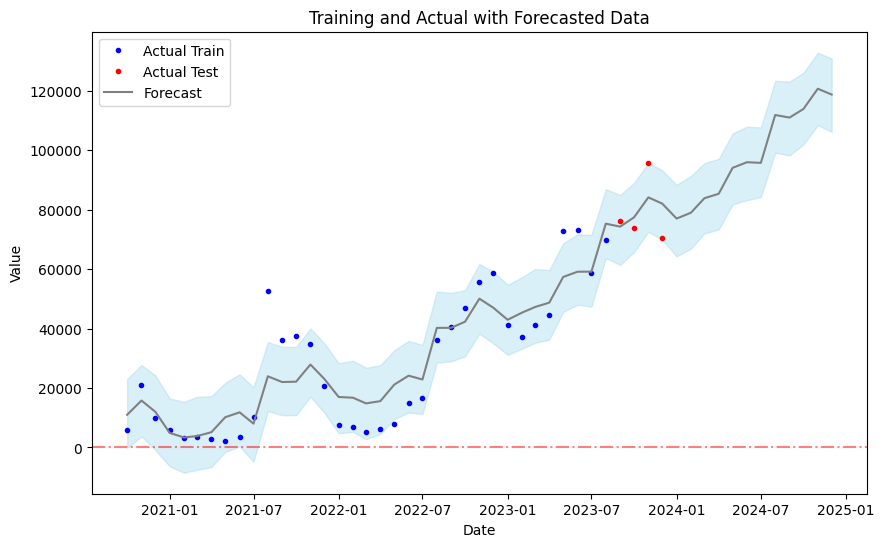

In [37]:
# show results
fig_1 = plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.plot(train["ds"], train["y"], '.', label='Actual Train', color = 'blue')
plt.plot(test["ds"], test["y"], '.', label='Actual Test', color = 'red')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='grey')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='skyblue', alpha=0.3)
plt.axhline(y=0, color='red', linestyle='-.', alpha = 0.5)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Training and Actual with Forecasted Data')
plt.legend()
plt.show()

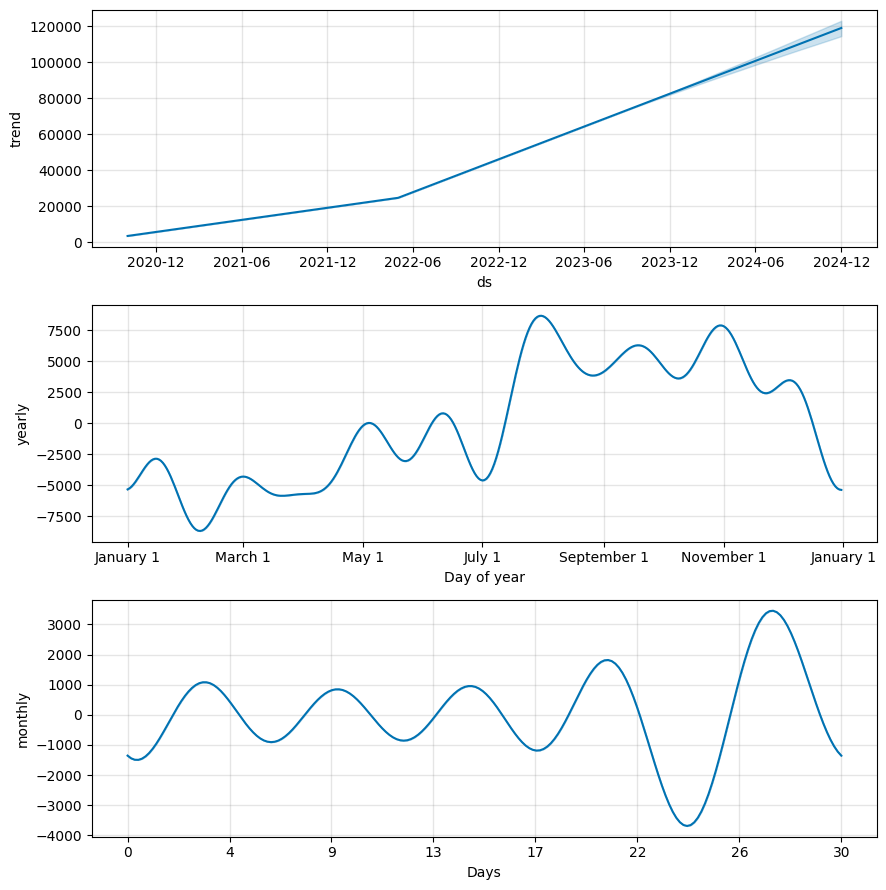

In [38]:
fig_2 = model.plot_components(forecast, plot_cap=20)

In [39]:
forecast_table = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].copy(deep=True)
forecast_table.columns = ['ds', 'y_forecast', 'y_upper', 'y_lower']
forecast_table['y_forecast'] = forecast_table['y_forecast'].apply(lambda x: round(x,0))
forecast_table['y_upper'] = forecast_table['y_upper'].apply(lambda x: round(x,0))
forecast_table['y_lower'] = forecast_table['y_lower'].apply(lambda x: round(x,0))

In [40]:
forecast_table.to_csv('ouput.csv')